In [1]:
#Loading libraries + train and test set

import pandas as pd
import math
import string
import numpy as np
import re
import time
import sklearn
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

start = time.time()

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/gender_submission.csv')

#Calculate category mean ages for filling missing values.

def mean_prefix(df):
    print(df.groupby['Name_prefix'].Age.mean())

#Defining preprocessing function    

def preprocess(df):
    df['Has_cabin'] = df.Cabin.apply(lambda x: True if pd.isnull(x) is False else False)
    df['Cabin_compartment'] = df.Cabin.apply(lambda x: re.findall('[A-Z]|$', str(x).strip())[0])
    df['Cabin_compartment_int'] = df.Cabin_compartment.apply(lambda x: pd.to_numeric(string.ascii_uppercase.index(x), errors='ignore'))
    df['Cabin_number'] = df.Cabin.apply(lambda x: pd.to_numeric(re.findall('[0-9]+|$', str(x).strip())[0]))
    df['Cabin'] = df.Cabin.apply(lambda x: re.findall('[A-Z][0-9]+|$', str(x).strip())[0])
    df['Relatives'] = df.SibSp + df.Parch
    df['Fare'] = df.Fare.apply(lambda x: x if x > 0 else None)
    df['Log_fare'] = df.Fare.apply(lambda x: math.log(x))
    df['Has_relatives'] = df.Relatives.apply(lambda x: True if x > 0 else False)
    df['Sex'] = df.Sex.apply(lambda x: 0 if x == 'female' else 1)
    df['Last_name'] = df.Name.apply(lambda x: x.split(' ')[0].replace(",",""))
    df['Name_prefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    
    prefixes = ['Lady', 'the Countess','Countess', 'Planke,', 'Don.', 'Rev.'
                'Billiard,' 'der', 'Walle,', 'Don', 'Jonkheer', 
                'Dona', 'Pelsmaeker,', 'Mulder,', 'y', 'Steen,', 'Carlo,', 'Impe,',
                'Gordon,', 'Messemaeker,', 'Velde,', 'the', 'Shawah,', 'Jonkheer.', 
                'Melkebeke,', 'Cruyssen,', 'Billiard,', 'der']
    
    male_prefixes = ['Capt.', 'Capt', 'Col.', 'Col', 'Major', 'Rev', 'Dr', 'Sir', 'Dr.', 'Major.', 'Rev.', 'Master', 'Master.']
    female_prefixes = ['Mlle.', 'Mme']

    prefixes = ['Mr.', 'Mrs.', 'Miss.']
    
    df["Name_prefix"] = df["Name_prefix"].replace(male_prefixes, 'Mr.').replace('Mlle.', 'Miss.').replace('Mme', 'Mrs.')
    df["Name_prefix"] = df["Name_prefix"].apply(lambda x: x if x in prefixes else 'Rare')
    
    #Filling NaN Age by mean of same Prefix and adding age quantile as feature.
    
    df['Age_replace'] = df.groupby(['Name_prefix']).Age.transform('mean')
    df['Age'] = df['Age'].fillna(df['Age_replace'])
    df.drop('Age_replace', axis=1)
    df['Q_age'] = pd.qcut(df['Age'], 7, labels=False)
    
    # Treat Ticket by extracting the ticket prefix. When there is no prefix return X. 

    Ticket = []
    for i in list(df.Ticket):
        if not i.isdigit() :
            Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
        else:
            Ticket.append("X")

    df["Ticket"] = Ticket
    df['Family_p_survived'] = df.groupby(['Last_name']).Survived.transform('sum')/train.groupby(['Last_name']).PassengerId.transform('count')
    
    return df

train = preprocess(train)
#test = preprocess(test)

end = time.time()

print("Execution time = {} seconds.".format(end-start))


C:\Users\Mehdi\Miniconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Mehdi\Miniconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Execution time = 0.09523653984069824 seconds.


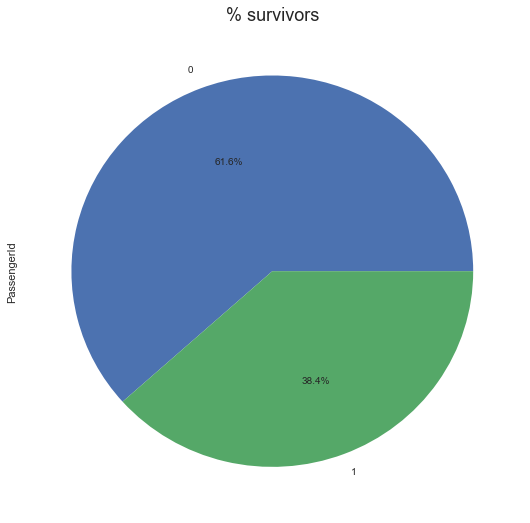

In [2]:
# Pie chart of survivals

count_by_survival = train.groupby('Survived').count()
count_by_survival['PassengerId'].plot(kind='pie', fontsize=10, 
                                autopct='%1.1f%%', figsize=(9,9))
plt.title('% survivors', fontsize=18)
plt.show()

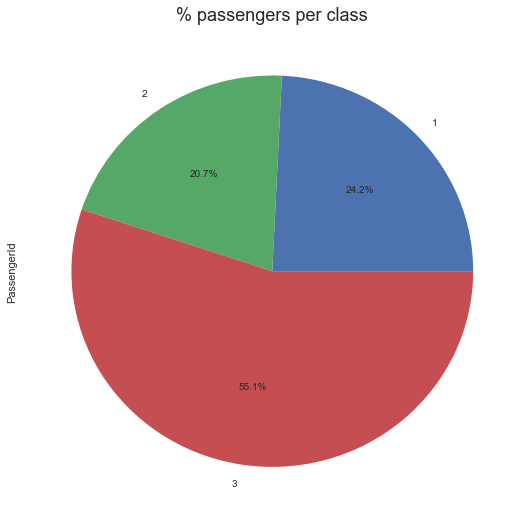

In [3]:
# Pie chart of passengers per class

passengers_per_class = train.groupby('Pclass').count()
passengers_per_class['PassengerId'].plot(kind='pie', fontsize=10, 
                                autopct='%1.1f%%', figsize=(9,9))
plt.title('% passengers per class', fontsize=18)
plt.show()

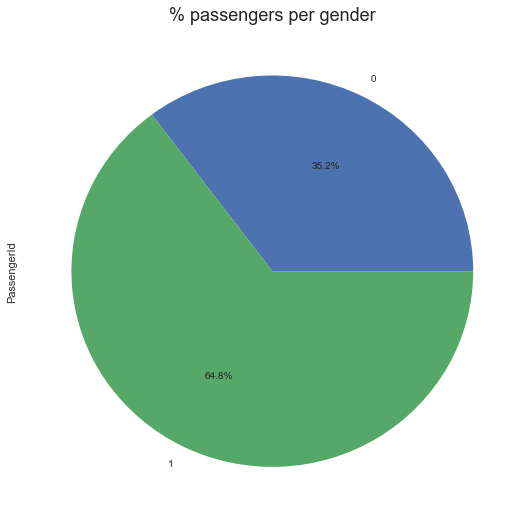

In [4]:
# Pie chart of passengers per gender

count_by_survival = train.groupby('Sex').count()
count_by_survival['PassengerId'].plot(kind='pie', fontsize=10, 
                                autopct='%1.1f%%', figsize=(9,9))
plt.title('% passengers per gender', fontsize=18)
plt.show()

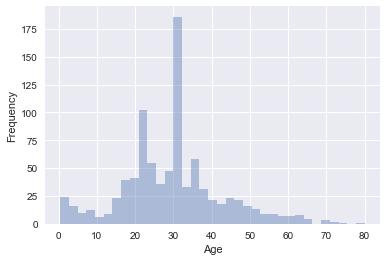

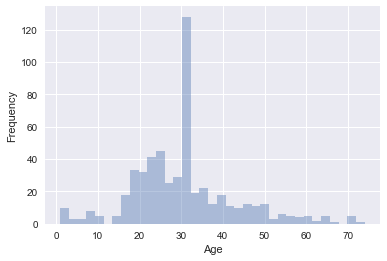

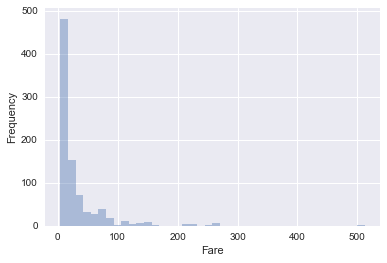

In [5]:
#Age distribution

ax = sns.distplot(train.Age.dropna(), bins=35, kde=False)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

#Let's check for the non-survivors

ax = sns.distplot(train[train.Survived == 0].Age.dropna(), bins=35, kde=False)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

#Fares distribution

ax = sns.distplot(train.Fare.dropna(), bins=40, kde=False)
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

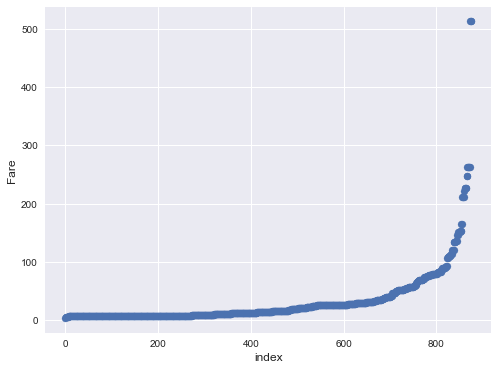

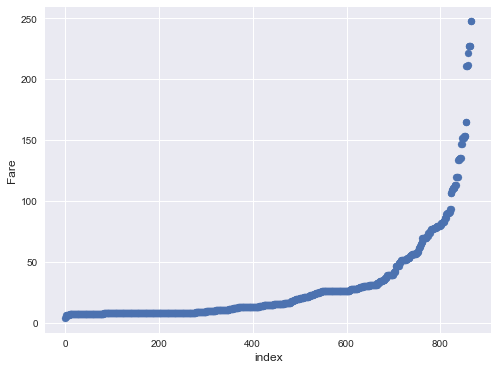

In [6]:
#Looks like there are outliers in the fare, let's check it.
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.Fare.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Fare', fontsize=12)
plt.show()

#Let's clean a bit although that's not real crazy outliers.
q = train.Fare.quantile(0.99)
train = train[train.Fare < q]

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.Fare.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Fare', fontsize=12)
plt.show()

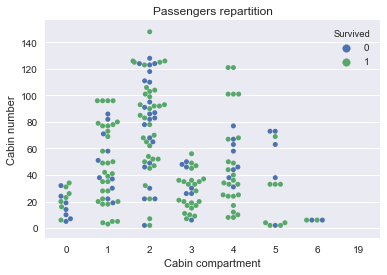

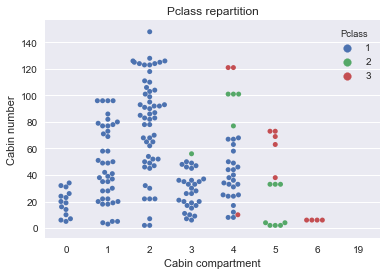

In [7]:
#Cabins Visualization

ax = sns.swarmplot(x="Cabin_compartment_int", y="Cabin_number", data=train,
                 hue='Survived')
plt.xlabel('Cabin compartment')
plt.ylabel('Cabin number')
plt.title('Passengers repartition')
plt.show()

ax = sns.swarmplot(x="Cabin_compartment_int", y="Cabin_number", data=train,
                 hue='Pclass')
plt.xlabel('Cabin compartment')
plt.ylabel('Cabin number')
plt.title('Pclass repartition')
plt.show()

    Pclass  Survived  Sex  counts
0        1         0    0       3
1        1         0    1      70
2        1         1    0      86
3        1         1    1      43
4        2         0    0       6
5        2         0    1      85
6        2         1    0      70
7        2         1    1      17
8        3         0    0      72
9        3         0    1     297
10       3         1    0      72
11       3         1    1      46


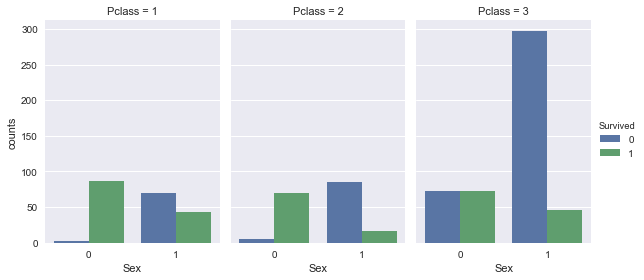

In [8]:
#Let's look at the repartition of Survivors and dead over Pclasses and Sex.

counts = train.groupby(['Pclass','Survived', 'Sex']).size().reset_index(name='counts')
print(counts)

g = sns.factorplot(x="Sex", y="counts",
                   hue="Survived", col="Pclass",
                   data=counts,
                   kind="bar",
                    size=4, aspect=.7);

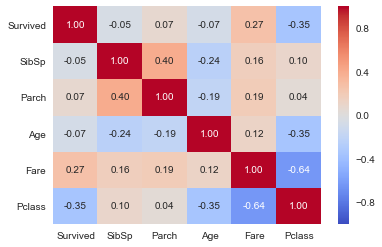

In [9]:
#Let's check the correlation matrix to see which features are the most correlated

g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare","Pclass"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

    Pclass  Survived  Woman_or_child  counts
0        1         0           False      72
1        1         0            True       1
2        1         1           False     124
3        1         1            True       5
4        2         0           False      91
5        2         1           False      68
6        2         1            True      19
7        3         0           False     336
8        3         0            True      33
9        3         1           False      93
10       3         1            True      25


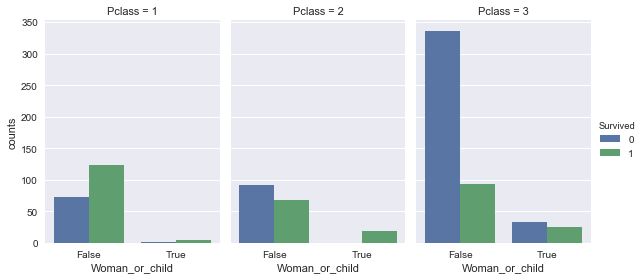

In [10]:
#Quite interesting findings above, useful for adding features for our model.

def social_group(sex, age, pclass):
    if age >= 0.0 and age <= 5.0: child = 'baby'
    elif age > 5.0 and age <= 16.0: child = 'child'
    elif age > 16.0 and age <= 30.0: child = 'young adult'
    elif age > 30.0 and age <= 50.0: child = 'adult'
    elif age > 50.0: child = 'senior'
    else: child = 'young adult'
    group = (str(sex) + '-' + child + '-' + str(pclass))
    return group

def woman_or_child(sex, age):
    if age < 16.0 or sex == 'female':
        return True
    else:
        return False
    
train['Social_group'] = train.apply(lambda x: social_group(x['Sex'], x['Age'], x['Pclass']), axis=1)
train['Woman_or_child'] = train.apply(lambda x: woman_or_child(x['Sex'], x['Age']), axis=1)

test['Social_group'] = test.apply(lambda x: social_group(x['Sex'], x['Age'], x['Pclass']), axis=1)
test['Woman_or_child'] = test.apply(lambda x: woman_or_child(x['Sex'], x['Age']), axis=1)

#Now let's check if "Women and children first" applied only to the wealthy ones.

counts = train.groupby(['Pclass','Survived', 'Woman_or_child']).size().reset_index(name='counts')
print(counts)

g = sns.factorplot(x="Woman_or_child", y="counts",
                   hue="Survived", col="Pclass",
                   data=counts,
                   kind="bar",
                    size=4, aspect=.7);

In [11]:
#Now, let's add as a new feature the probability of dying grouped by pclass, and sex.

train['Sgroup_p_survived'] = train.groupby(['Social_group']).Survived.transform('sum')/train.groupby(['Social_group']).PassengerId.transform('count')

s_ratio = train.groupby(['Social_group', 'Sgroup_p_survived']).size()
print(s_ratio)

Social_group     Sgroup_p_survived
0-adult-1        0.977273              44
0-adult-2        0.925926              27
0-adult-3        0.387097              31
0-baby-1         0.000000               1
0-baby-2         1.000000               5
0-baby-3         0.733333              15
0-child-1        1.000000               5
0-child-2        1.000000               5
0-child-3        0.388889              18
0-senior-1       1.000000              13
0-senior-2       0.666667               3
0-senior-3       1.000000               1
0-young adult-1  0.961538              26
0-young adult-2  0.916667              36
0-young adult-3  0.518987              79
1-adult-1        0.396825              63
1-adult-2        0.157895              38
1-adult-3        0.110429             163
1-baby-1         1.000000               2
1-baby-2         1.000000               8
1-baby-3         0.384615              13
1-child-1        1.000000               1
1-child-2        0.333333               3

LogisticRegression: 0.846153846154
Naive Bayes: 0.512307692308
Decision Tree: 0.847692307692
Random Forest: 0.915384615385


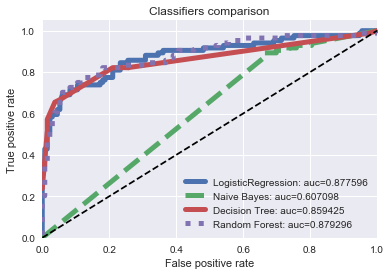

In [34]:
#Evaluation of best model using ROC curve and AUC

features = ['Age', 'Pclass', 'Sex', 'Log_fare', 'Has_cabin','Cabin_compartment_int', 
            'Age', 'Cabin_number','Relatives', 'Has_relatives', 'Woman_or_child', 'Social_group', 'Ticket', 'Name_prefix', 
            'Q_age', 'Sgroup_p_survived']


CLASS_MAP = {
    'LogisticRegression' : ('-', LogisticRegression()),
    'Naive Bayes' : ('--', GaussianNB()),
    'Decision Tree': ('.-', DecisionTreeClassifier(max_depth=5)),
    'Random Forest': (':', RandomForestClassifier())
}

param_grid = {
             'n_estimators': [40, 70, 100],
             'max_depth': [2, 5, 7, 9],
             'max_features': [2, 5, 7, 9]
         }

scl = StandardScaler()

target = train['Survived'] == 1

feat = train[features].fillna(0)
feat = pd.get_dummies(feat)

X, Y = feat, target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =.25)

X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

for name, (line_fmt, model) in CLASS_MAP.items():

    if name == 'Random Forest':
        model = GridSearchCV(model, param_grid, cv=10)

    model.fit(X_train, Y_train)
    preds = model.predict_proba(X_test)
    pred = pd.Series(preds[:,1])
    fpr, tpr, thresholds = roc_curve(Y_test, pred)
    auc_score = auc(fpr, tpr)
    classic_score = model.score(X_train, Y_train)
    display_score = name + ": " + str(classic_score)
    print(display_score)
    label = '%s: auc=%f' % (name, auc_score)
    plt.plot(fpr, tpr, line_fmt, linewidth=5, label=label)

plt.legend(loc="lower right")
plt.title("Classifiers comparison")
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()